for better visualization of the data refer to data_visual.py

In [679]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from skopt import BayesSearchCV
from skopt.space import Real,Categorical,Integer
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In [680]:
# Load Data.   
file_path = 'home_price_cleaned_OHE.csv'  
df = pd.read_csv(file_path)

target_col = 'Fiyat' 

X = df.drop('Fiyat',axis =1)
y = df['Fiyat']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaling (Important for Lasso and MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate the threshold for classification metrics (e.g., Median Price)
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19161 entries, 0 to 19160
Columns: 124 entries, Net_Metrekare to Tapu_Durumu_Müstakil Tapulu
dtypes: float64(4), int64(120)
memory usage: 18.1 MB


evaluation function. calculated 3 different performance metrics and also the train performance to test for overfitting

In [681]:
def evaluate_and_log(model, X_test, y_test, X_train, y_train, model_name):
    """
    Evaluates a regression model using MAE, RMSE, and R2 Score.
    Plots Actual vs. Predicted values.
    """
    
    # 1. Make Predictions
    y_pred = model.predict(X_test)
    
    print(f"\n--- Evaluation for {model_name} ---\n")

    # 2. Calculate Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred)

    # 3. Print Results
    print("Training Score: ", model.score(X_train, y_train))
    print(f"R² Score (Accuracy):  {r2:.2%}") # Closer to 100% is better
    print(f"MAE (Avg Error):      {mae:,.0f} TL") # On average, how wrong are we?
    print(f"RMSE (Large Error):   {rmse:,.0f} TL") # Penalizes huge mistakes more
    
    # 4. Visual Evaluation: Actual vs Predicted Plot
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of data points
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='coral', edgecolor='k', s=50)
    
    # The "Perfect Prediction" Line (Diagonal)
    # If a point is on this line, the prediction was 100% correct
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', linewidth=2, label='Perfect Prediction')

    plt.title(f'{model_name}: Actual Prices vs Predicted Prices', fontsize=14, fontweight='bold')
    plt.xlabel('Actual Price (True Value)', fontsize=12)
    plt.ylabel('Predicted Price (Model Guess)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Use log scale if your prices have a huge range (optional, but recommended for Real Estate)
    plt.xscale('log')
    plt.yscale('log')
    
    plt.show()

# Example Usage:
# evaluate_regression(rf_model, X_test, y_test, "Random Forest")

After some Testing LightGBM was chossen as the main model since it had the beest accuracay without overfitting

tested 2 types of parameter tuning the second model was chosen

Training LightGBM (Randomized Search)...
Best Randomized Search parameters: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 15, 'n_estimators': 200, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

--- Evaluation for LightGBM_Randomized ---

Training Score:  0.7265782699772649
R² Score (Accuracy):  68.63%
MAE (Avg Error):      691,722 TL
RMSE (Large Error):   1,404,776 TL


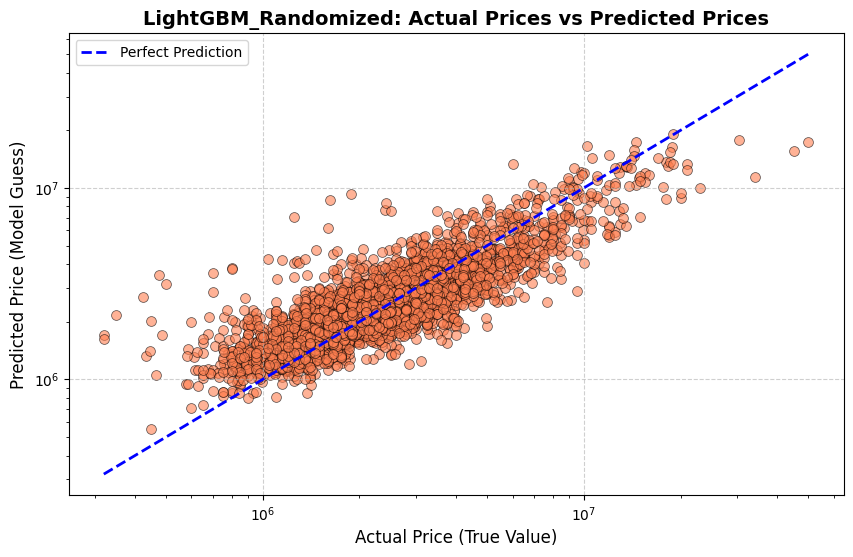

In [682]:
lgbm_extended_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 50, 100, 200],
    'min_child_samples': [10, 20, 50],  
    'subsample': [0.8, 0.9, 1.0],  
    'colsample_bytree': [0.8, 0.9, 1.0],  
    'reg_alpha': [0, 0.1, 1.0],  
    'reg_lambda': [0, 0.1, 1.0]  
}

# Use RandomizedSearchCV instead for faster exploration
from sklearn.model_selection import RandomizedSearchCV

random_lgbm = RandomizedSearchCV(
    LGBMRegressor(random_state=42, verbose=-1),
    param_distributions=lgbm_extended_params,
    n_iter=50,  # Try 50 random combinations
    cv=3,
    n_jobs=-1,
    scoring='r2',  # or 'neg_mean_squared_error'
    random_state=42
)

print("Training LightGBM (Randomized Search)...")
random_lgbm.fit(X_train, y_train)

print("Best Randomized Search parameters:", random_lgbm.best_params_)
evaluate_and_log(random_lgbm, X_test, y_test, X_train, y_train, "LightGBM_Randomized")

Training LightGBM (Random Search)...
Best parameters: {'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.03}

--- Evaluation for LightGBM (Random-Fixed) ---

Training Score:  0.7766584060875894
R² Score (Accuracy):  70.19%
MAE (Avg Error):      685,350 TL
RMSE (Large Error):   1,369,304 TL


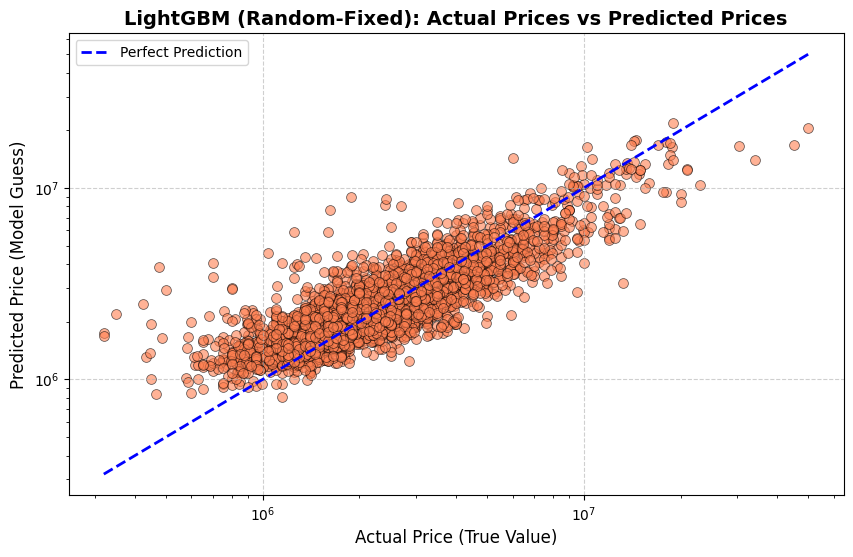

In [683]:
random_lgbm = RandomizedSearchCV(
    estimator=LGBMRegressor(
        random_state=42,
        boosting_type="gbdt",
        objective="regression",
        force_col_wise=True
    ),
    param_distributions={
        "num_leaves": [31, 50, 70],
        "max_depth": [-1, 10, 20, 30],
        "learning_rate": [0.03, 0.05, 0.1],
        "n_estimators": [200, 300, 400],
        "min_child_samples": [10, 20, 30]
    },
    n_iter=30,
    cv=3,
    n_jobs=-1,
    random_state=42
)

print("Training LightGBM (Random Search)...")
random_lgbm.fit(X_train, y_train)

print("Best parameters:", random_lgbm.best_params_)
evaluate_and_log(random_lgbm, X_test, y_test, X_train, y_train, "LightGBM (Random-Fixed)")
